## Imports

In [1]:

# Importem llibreries necessàries
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import matplotlib

sns.set()
# import os
# import torch
# from torch.nn.functional import softmax

# Import custom functions
import sys
sys.path.insert(0, "code/")

# from bias_utils import setup_models, setup_device, setup_logger
# from bias_utils import print_topk, get_topk
# from bias_utils import get_inputs_logits_probs, get_mask_indices, uni_tokenize
from viz_utils import ax_histogram, ax_boxplot, viz_scores

In [2]:
print("Pandas:", pd.__version__)
print("Seaborn:", sns.__version__)
print("Matplotlib:", matplotlib.__version__)

Pandas: 1.5.0
Seaborn: 0.11.2
Matplotlib: 3.6.1


## Read scores file

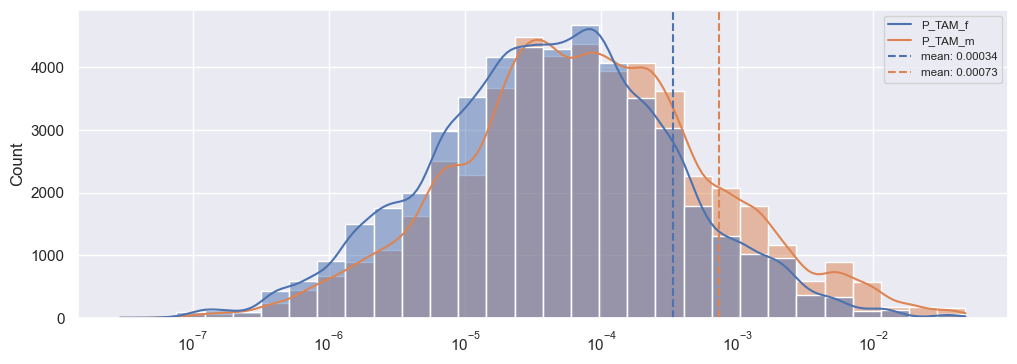

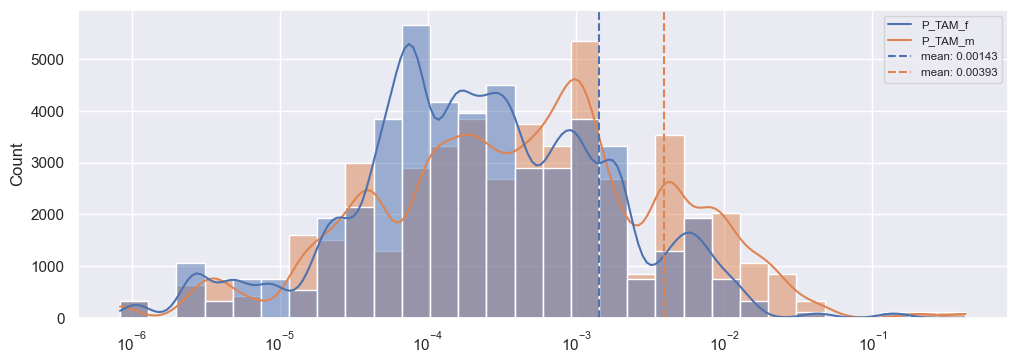

In [6]:
# Carreguem les dades
DATA = "data/"

df_scores = pd.read_csv(DATA + "scores-cat_target-professions.csv")
df_scores2 = pd.read_csv(DATA + "scores-cat_target-persones.csv")

# Visualitzem Mitjanes TAM => Paraula objectiu (Professions)
fig, ax = plt.subplots(figsize=(12,4))
ax_histogram(df_scores[["P_TAM_f", "P_TAM_m"]], log_scale=True, ax=ax);

# Visualitzem Mitjanes TAM => Paraula objectiu (Gènere)
fig, ax = plt.subplots(figsize=(12,4))
ax_histogram(df_scores2[["P_TAM_f", "P_TAM_m"]], log_scale=True, ax=ax);

<AxesSubplot: ylabel='Count'>

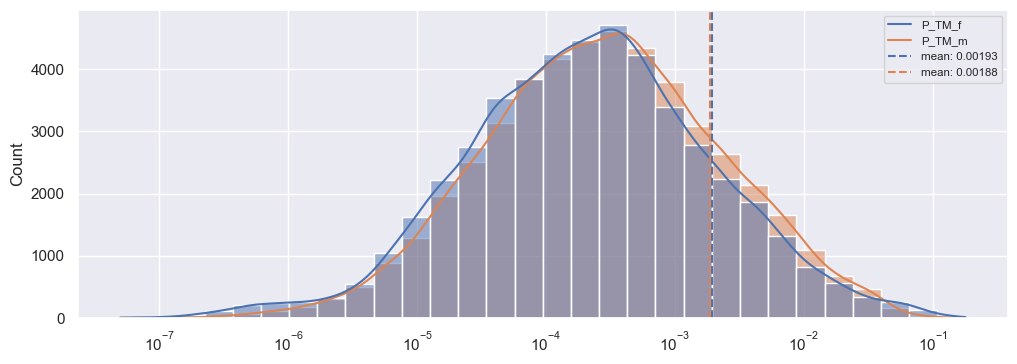

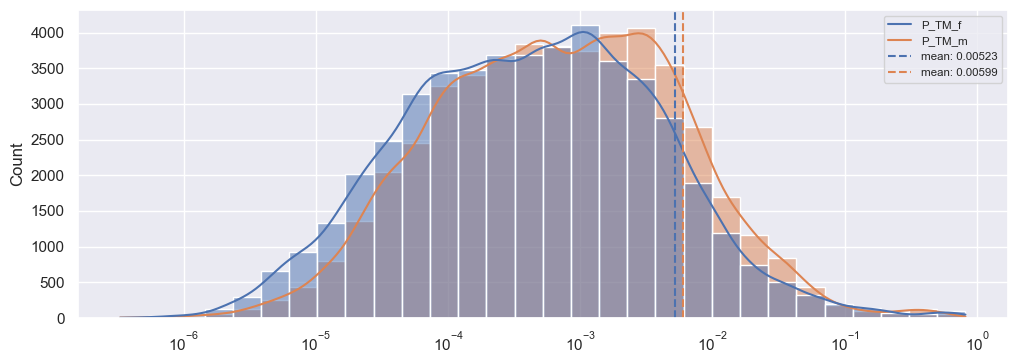

In [9]:
# Visualitzem Mitjanes TM => Paraula objectiu (Professions)
fig, ax = plt.subplots(figsize=(12,4))
ax_histogram(df_scores[["P_TM_f", "P_TM_m"]], log_scale=True, ax=ax)

# Visualitzem Mitjanes TM =>  Paraula objectiu (Gènere)
fig, ax = plt.subplots(figsize=(12,4))
ax_histogram(df_scores2[["P_TM_f", "P_TM_m"]], log_scale=True, ax=ax)

## Visualitza resultats

In [10]:
same_word = (df_scores.word_f == df_scores.word_m)
same_word2 = (df_scores2.word_f == df_scores2.word_m)

print("Professions amb la mateixa paraula per home i dona:", df_scores[same_word].words.unique().shape[0])
print("Professions amb paraules diferents per home i dona:", df_scores[~same_word].words.unique().shape[0])

Professions amb la mateixa paraula per home i dona: 49
Professions amb paraules diferents per home i dona: 58


##### Annex - Resultats per professions

In [11]:
cols = ["words", "P_TAM_m", "P_TAM_f", "P_TAM_odds", "P_TM_m",  "P_TM_f", "Asso_m", "Asso_f", "Asso_diff"]

# Agrupem els resultats
group1 = df_scores.loc[~same_word,cols].groupby("words").mean().sort_values("P_TAM_odds").reset_index()

group2 = df_scores.loc[same_word,cols].groupby("words").mean().sort_values("Asso_diff").reset_index()

# Convertim les probabilitats en tant prt 1000.
cols = ["P_TAM_m", "P_TM_m", "P_TAM_f", "P_TM_f"]
group1[cols] = group1[cols]*1000
group2[cols] = group2[cols]*1000


# Mostrem els resultats
display(group1.style.applymap(lambda v, props: props if v < 0 else None, props='color:red;', 
                              subset=["Asso_m", "Asso_f", "P_TAM_odds", "Asso_diff"]).format(precision=3))

display(group2.style.applymap(lambda v, props: props if v < 0 else None, props='color:red;', 
                              subset=["Asso_m", "Asso_f", "Asso_diff"]).format(precision=3))

# Guardem els resultats
group1.to_excel(DATA+"Annex - Resultats professions (mateixa paraula).xlsx")
group2.to_excel(DATA+"Annex - Resultats professions (diferent paraula).xlsx")

,words,P_TAM_m,P_TAM_f,P_TAM_odds,P_TM_m,P_TM_f,Asso_m,Asso_f,Asso_diff
0,carter/cartera,0.141,0.002,-3.556,0.639,0.001,2.434,-0.421,-2.855
1,jutge/jutgessa,0.679,0.055,-2.689,1.526,0.197,1.193,1.833,0.640
2,metge/metgessa,2.034,0.195,-2.465,18.957,4.876,2.147,3.263,1.115
3,funcionari/funcionària,6.617,0.447,-2.369,7.264,2.040,1.001,2.444,1.443
4,alcalde/alcaldessa,4.361,0.338,-2.365,5.875,1.333,0.537,1.367,0.830
5,historiador/historiadora,0.780,0.082,-2.266,4.463,0.874,1.309,2.650,1.341
6,mecànic/mecànica,1.241,0.032,-2.200,4.944,0.083,2.447,0.745,-1.702
7,pintor/pintora,2.074,0.153,-1.994,7.001,2.319,2.333,3.712,1.378
8,còmic/còmica,0.110,0.014,-1.983,0.208,0.030,0.789,0.798,0.009
9,productor/productora,0.125,0.013,-1.971,0.241,0.066,0.993,1.872,0.878


,words,P_TAM_m,P_TAM_f,P_TAM_odds,P_TM_m,P_TM_f,Asso_m,Asso_f,Asso_diff
0,bateria,0.017,0.017,0.000,0.184,0.019,1.878,0.232,-1.646
1,paleta,0.541,0.541,0.000,4.969,1.200,1.792,0.493,-1.300
2,comerciant,0.032,0.032,0.000,0.192,0.052,1.862,0.765,-1.098
3,soldat,0.429,0.429,0.000,0.871,0.354,1.401,0.306,-1.095
4,àrbitre,0.205,0.205,0.000,0.180,0.064,0.205,-0.878,-1.083
5,taxista,0.946,0.946,0.000,4.030,1.277,2.716,1.669,-1.048
6,policia,0.829,0.829,0.000,2.373,0.937,1.531,0.646,-0.885
7,comentarista,0.048,0.048,0.000,0.040,0.018,-0.045,-0.803,-0.758
8,guarda,0.013,0.013,0.000,0.030,0.011,0.628,-0.116,-0.744
9,guitarrista,0.055,0.055,0.000,0.318,0.106,2.207,1.465,-0.742


## 4.1 Professions amb marca de gènere (paraules diferents home/dona)

### 4.1.1. Context sense gènere - Paraules diferents


* Figura 4 - Comparació de probabilitats en context sense gènere (paraules masculines/femenines diferents).
* Figura 5 - Distribució de probabilitats en context sense gènere.
* Figura 6 -Distribució de probabilitats en context sense gènere (professions "femenines")
* *Annex - Probabilitats ballarina agrupat per template.*
* Figura 7 - Probabilitats ballarina/ballarí (context sense gènere) agrupat per plantilla (escala log.)
* Figura 8 - Probabilitats ballarina/ballarí (context sense gènere) agrupat per plantilla
* Figura 9 - Distribució de probabilitats en context sense gènere (professions "masculines")
* *Annex - Probabilitats pintor agrupat per template.*
* Figura 10 - Probabilitats pintor/pintora (context sense gènere) agrupat per plantilla (escala log.)
* Figura 11 - Probabilitats pintor/pintora (context sense gènere) agrupat per plantilla

#### Context sense gènere - Paraules diferents

* Figura 4 - Comparació de probabilitats en context sense gènere (paraules masculines/femenines diferents).
* Figura 5 - Distribució de probabilitats en context sense gènere.

In [12]:
# agg = {"P_TAM_f": "mean", "P_TAM_m": "mean"}
cols = ["words", "P_TAM_m", "P_TAM_f", "P_TAM_odds"]
# df_scores[~same_word].groupby("words").agg(agg).reset_index()

# Agrupem els resultats de cada professió i obtenim les mitjanes
group = df_scores[~same_word][cols].groupby("words").mean().reset_index()

# Obtenim les "Odds"
group['Odds'] = group['P_TAM_odds'].sort_values().apply(lambda v: np.exp(v) if v>0 else np.exp(v)**-1)
group['Odds2'] = group.apply(lambda r: r.P_TAM_f/r.P_TAM_m if r.P_TAM_f > r.P_TAM_m else r.P_TAM_m/r.P_TAM_f, axis=1)


# Obtenim les professions masculines
# group_male = group[group['P_TAM_m'] > group['P_TAM_f']]
# group_female = group[group['P_TAM_m'] < group['P_TAM_f']]
group_male = group[group['P_TAM_odds'] < 0]
group_female = group[group['P_TAM_odds'] > 0]

print("Probs. paraules masculines > Probs. paraules femenines", len(group_male))
print("Probs. paraules masculines +20% (Probs. paraules femenines)", (group['P_TAM_odds'] < np.log(1.2**-1)).sum())
display(group_male.sort_values("Odds").tail(10))

print("Probs. paraules femenines > Probs. paraules masculines", len(group_female))
print("Probs. paraules femenines +20% (Probs. paraules masculines)", (group['P_TAM_odds'] > np.log(1.2)).sum())
display(group_female.sort_values("Odds").tail(10))


# group.to_excel(DATA + "scores-cat_same-word.xlsx", index=False)

Probs. paraules masculines > Probs. paraules femenines 50
Probs. paraules masculines +20% (Probs. paraules femenines) 48


,words,P_TAM_m,P_TAM_f,P_TAM_odds,Odds,Odds2
49,productor/productora,0.000125,0.000013,-1.971121,7.178723,9.734753
19,còmic/còmica,0.000110,0.000014,-1.983445,7.267739,7.910814
45,pintor/pintora,0.002074,0.000153,-1.993626,7.342108,13.572500
39,mecànic/mecànica,0.001241,0.000032,-2.200082,9.025754,38.771575
34,historiador/historiadora,0.000780,0.000082,-2.266476,9.645350,9.493232
4,alcalde/alcaldessa,0.004361,0.000338,-2.365079,10.644875,12.907283
32,funcionari/funcionària,0.006617,0.000447,-2.368535,10.681732,14.812282
41,metge/metgessa,0.002034,0.000195,-2.464784,11.760941,10.428417
37,jutge/jutgessa,0.000679,0.000055,-2.689206,14.719981,12.414291
11,carter/cartera,0.000141,0.000002,-3.556317,35.033918,76.338683


Probs. paraules femenines > Probs. paraules masculines 8
Probs. paraules femenines +20% (Probs. paraules masculines) 6


,words,P_TAM_m,P_TAM_f,P_TAM_odds,Odds,Odds2
40,mestre/mestra,0.001685,0.001811,0.018541,1.018714,1.074675
24,doctor/doctora,0.000172,0.000180,0.057954,1.059666,1.047487
47,presentador/presentadora,0.000035,0.000037,0.215312,1.240249,1.044978
33,físic/física,0.000072,0.000093,0.263917,1.302021,1.288137
30,farmacèutic/farmacèutica,0.000029,0.000084,0.658291,1.931488,2.859967
7,ballarí/ballarina,0.000066,0.000273,0.866087,2.377590,4.134061
8,bibliotecari/bibliotecària,0.000021,0.000083,0.881769,2.415167,3.963241
29,estadístic/estadística,0.000012,0.000034,0.966544,2.628844,2.852287


##### Figura - Comparació de probabilitats en context sense gènere (paraules masculines/femenines diferents).

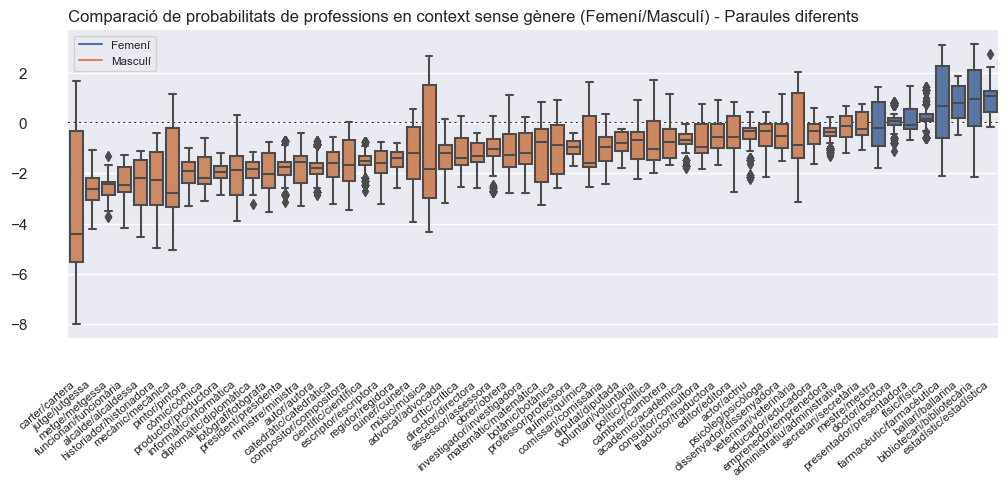

In [14]:
# ==================================================================================================
# Context sense gènere - Paraules diferents

title="Comparació de probabilitats de professions en context sense gènere (Femení/Masculí) - Paraules diferents"
ax_boxplot(df_scores[~same_word], col_score="P_TAM_odds", x_col="words", title_loc="left", 
           title=title);

# ax.xaxis.set_major_formatter(mpl.ticker.ScalarFormatter())
# ax.set_xticks([1e-7, 1e-6, 5e-6, 1e-5, 1e-4, 1e-3]);

##### Figura  - Distribució de probabilitats en context sense gènere.

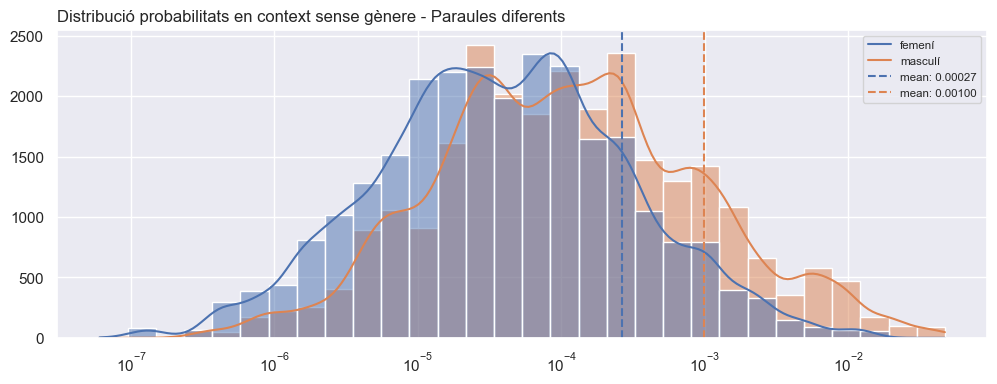

In [15]:
fig, ax = plt.subplots(figsize=(12,4))
title = "Distribució probabilitats en context sense gènere - Paraules diferents"
ax_histogram(df_scores[~same_word][["P_TAM_f", "P_TAM_m"]], labels=["femení", "masculí"], 
             log_scale=True, ax=ax, title=title, title_loc="left", ylabel="");


#### Context sense gènere - Distribució de probabilitats 4 female profs

* Figura 6 -Distribució de probabilitats en context sense gènere (professions "femenines")

##### Figura 6 -Distribució de probabilitats en context sense gènere (professions "femenines")

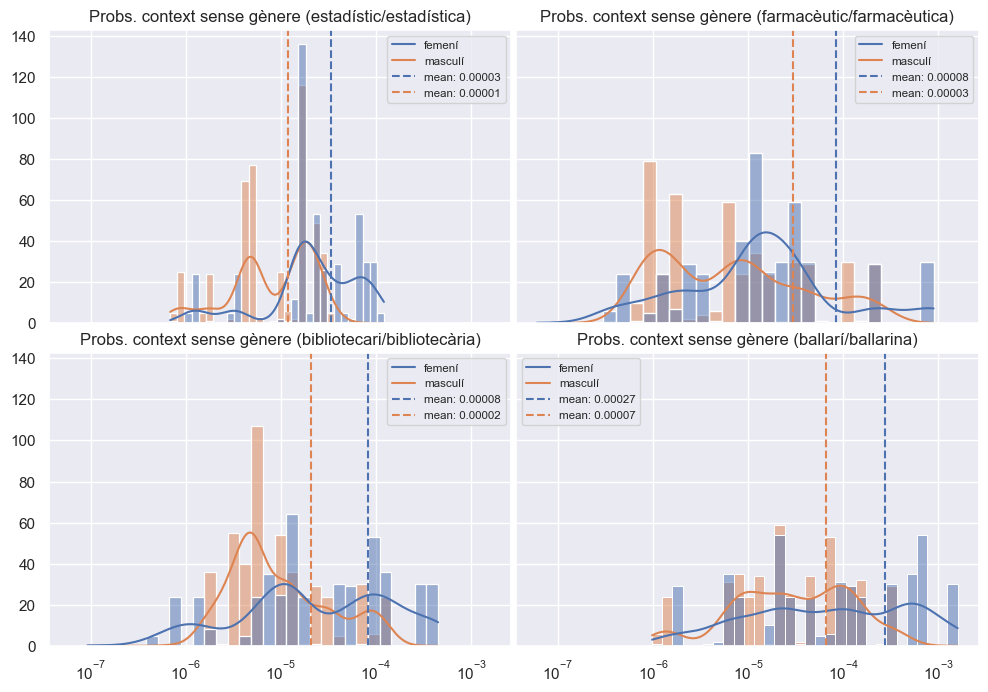

In [16]:
female_profs =  ["estadístic", "farmacèutic", "bibliotecari", "ballarí" ]

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(ncols=2, nrows=2, figsize=(12,8), sharex=True, sharey=True)
for prof, ax in zip(female_profs, (ax1, ax2, ax3, ax4)):
    data = df_scores[df_scores.word_m == prof]
    title = f"Probs. context sense gènere ({data.words.values[0]})"

    ax_histogram(data[["P_TAM_f", "P_TAM_m"]], labels=["femení", "masculí"], 
                 log_scale=True, ax=ax, title=title, ylabel="");

    plt.subplots_adjust(hspace=0.1, wspace=0.01)

#### Exemple: Probabilitats ballarina/ballarí agrupades per template

* Annex - Probabilitats ballarina agrupat per template.
* Figura 7 - Probabilitats ballarina/ballarí (context sense gènere) agrupat per plantilla (escala log.)
* Figura 8 - Probabilitats ballarina/ballarí (context sense gènere) agrupat per plantilla

##### Annex - Probabilitats ballarina agrupat per template.

In [17]:
data = df_scores[df_scores.word_m == "ballarí"]

# Mitjanes de probabilitats (P_TAM) en contextos sense especificar gènere agrupades per "template" 
group = data[["template", "P_TAM_m","P_TAM_f", "P_TM_m","P_TM_f"]].groupby("template").mean()
group = group.sort_values("P_TAM_f").reset_index()

group["Prop_TAM"] = group["P_TAM_f"]/group["P_TAM_m"]
group["Prop_TM"] = group["P_TM_f"]/group["P_TM_m"]

# Mostrem el valors agrupats
group.style.set_properties(subset=['template'], **{'width': '480px', 'text-align': 'left'})

,template,P_TAM_m,P_TAM_f,P_TM_m,P_TM_f,Prop_TAM,Prop_TM
0,"No m'agrada parlar de feina, però [GENDER_WORD] és [ATTR_WORD].",0.000001,0.000002,0.000070,0.000374,1.310320,5.304318
1,"Parlem de professions, [GENDER_WORD] és [ATTR_WORD].",0.000006,0.000006,0.000714,0.003902,1.085101,5.468766
2,[GENDER_WORD] és [ATTR_WORD].,0.000009,0.000007,0.000336,0.001330,0.777627,3.955072
3,"[GENDER_WORD] és [ATTR_WORD], ha tingut un mal dia a la feina.",0.000009,0.000019,0.000094,0.000479,2.182035,5.087493
4,"[GENDER_WORD] és [ATTR_WORD], ha tingut un bon dia a la feina.",0.000012,0.000019,0.000121,0.000527,1.601096,4.350000
5,Saps que [GENDER_WORD] és [ATTR_WORD]?,0.000021,0.000026,0.000210,0.001346,1.216431,6.423072
6,L'altre dia vaig saber que [GENDER_WORD] és [ATTR_WORD].,0.000043,0.000048,0.000254,0.001148,1.132616,4.515861
7,Jo vull ser [ATTR_WORD] com [GENDER_WORD].,0.000021,0.000093,0.000091,0.001226,4.539174,13.540382
8,Jo no vull ser [ATTR_WORD] com [GENDER_WORD].,0.000028,0.000111,0.000081,0.000724,3.913510,8.887968
9,[GENDER_WORD] vol ser [ATTR_WORD].,0.000072,0.000134,0.000570,0.004593,1.854627,8.052391


In [18]:
# => "Annex - Probabilitats ballarina agrupat per template."

# Guardem l'arxiu excel que es mostrarà a l'annex
# group.to_excel(DATA+"Annex - Probabilitats ballarina agrupat per template.xlsx", index=False)

##### Figura 7 - Probabilitats ballarina/ballarí (context sense gènere) agrupat per plantilla (escala log.) 

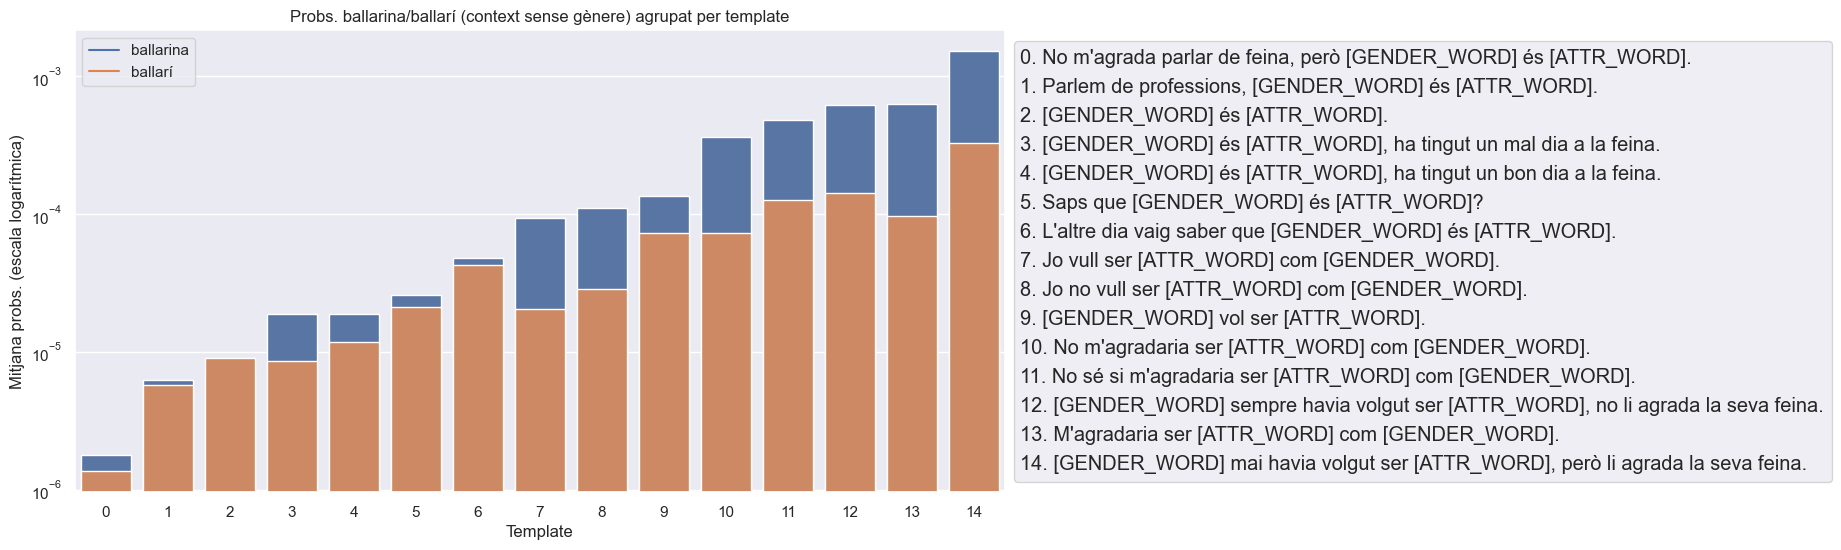

In [19]:
fig, ax = plt.subplots(figsize=(12,6))

# ax = sns.barplot(data=group, x="index", y="P_TAM_f", color="b")
sns.barplot(x=group.index, y=group.P_TAM_f, color="b", )
sns.barplot(x=group.index, y=group.P_TAM_m, color=sns.color_palette()[1])

ax.set_yscale("log")
ax.set(xlabel="Template", ylabel="Mitjana probs. (escala logarítmica)", 
       title="Probs. ballarina/ballarí (context sense gènere) agrupat per template")

first_legend = ax.legend([Line2D([0],[0], color="b"), 
                          Line2D([0],[0], color=sns.color_palette()[1])], 
                          ["ballarina", "ballarí"])

ax.add_artist(first_legend)

templates = [f"{i}. {t}" for i,t in enumerate(group.template)]
ax.legend(labels=templates, bbox_to_anchor=(1.01, .5), loc='center left',
          handletextpad=-.1, handlelength=0, borderaxespad=0, fontsize="large");

##### Figura 8 - Probabilitats ballarina/ballarí (context sense gènere) agrupat per plantilla

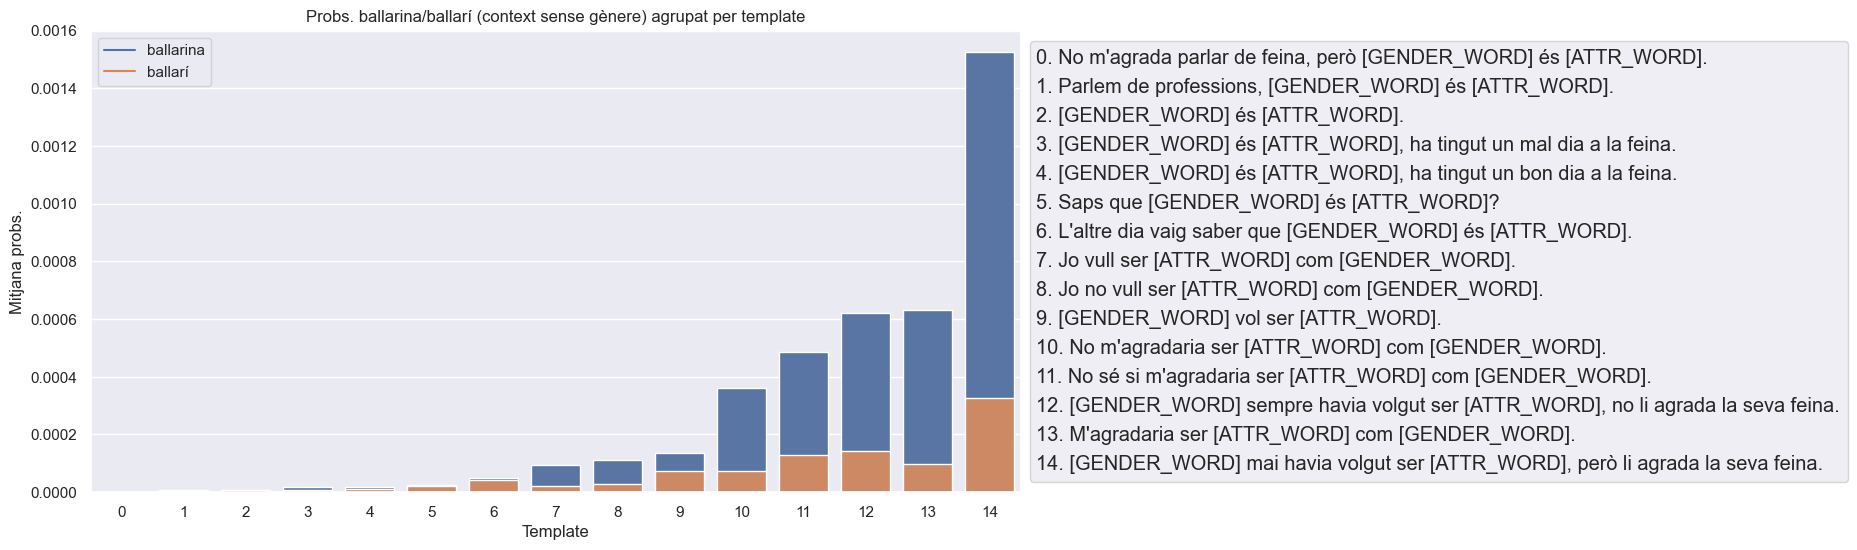

In [20]:
fig, ax = plt.subplots(figsize=(12,6))

# ax = sns.barplot(data=group, x="index", y="P_TAM_f", color="b")
sns.barplot(x=group.index, y=group.P_TAM_f, color="b", )
sns.barplot(x=group.index, y=group.P_TAM_m, color=sns.color_palette()[1])

# ax.set_yscale("log")
ax.set(xlabel="Template", ylabel="Mitjana probs.", 
       title="Probs. ballarina/ballarí (context sense gènere) agrupat per template")

first_legend = ax.legend([Line2D([0],[0], color="b"), 
                          Line2D([0],[0], color=sns.color_palette()[1])], 
                          ["ballarina", "ballarí"])

ax.add_artist(first_legend)

templates = [f"{i}. {t}" for i,t in enumerate(group.template)]
ax.legend(labels=templates, bbox_to_anchor=(1.01, .5), loc='center left',
          handletextpad=-.1, handlelength=0, borderaxespad=0, fontsize="large");

#### Context sense gènere - Distribució de probabilitats 4 male profs

* Figura 9 - Distribució de probabilitats en context sense gènere (professions "masculines")

##### Figura 9 - Distribució de probabilitats en context sense gènere (professions "maculines")

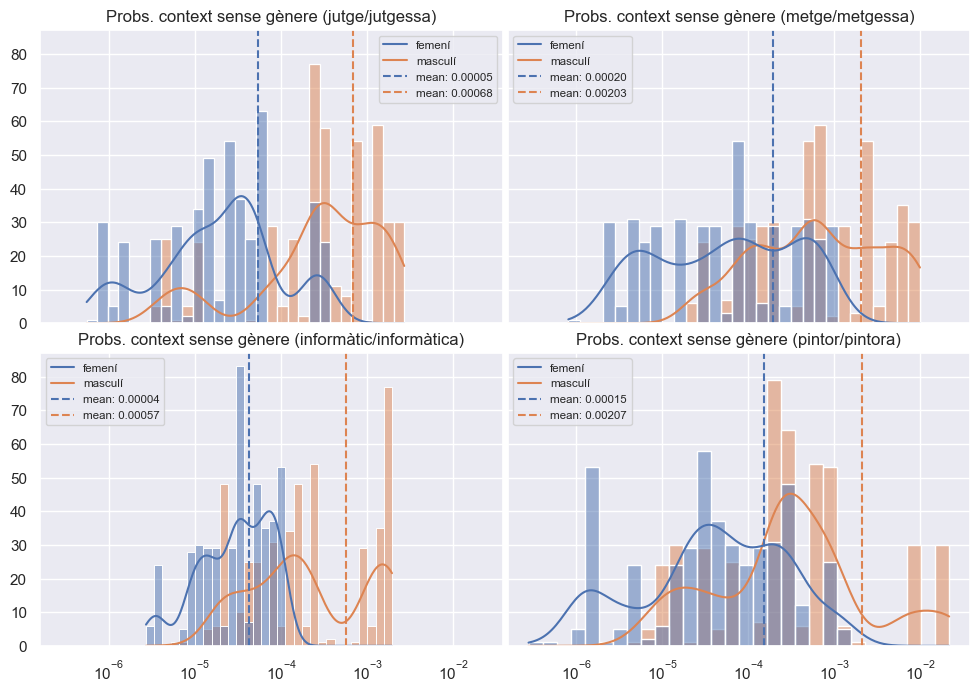

In [21]:
male_profs = ["jutge", "metge", "informàtic", "pintor"]
# male_profs = ["informàtic", "funcionari", "mecànic", "carter"]


fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(ncols=2, nrows=2, figsize=(12,8), sharex=True, sharey=True)
for prof, ax in zip(male_profs, (ax1, ax2, ax3, ax4)):
    data = df_scores[df_scores.word_m == prof]
    title = f"Probs. context sense gènere ({data.words.values[0]})"

    ax_histogram(data[["P_TAM_f", "P_TAM_m"]], labels=["femení", "masculí"], 
                 log_scale=True, ax=ax, title=title, ylabel="");

    plt.subplots_adjust(hspace=0.1, wspace=0.01)

#### Probabilitats pintor/pintora agrupades per plantilla

* Annex - Probabilitats pintor agrupat per template.
* Figura 10 - Probabilitats pintor/pintora (context sense gènere) agrupat per plantilla (escala log.)
* Figura 11 - Probabilitats pintor/pintora (context sense gènere) agrupat per plantilla

##### Annex - Probabilitats pintor agrupat per template.

In [22]:
data = df_scores[df_scores.word_m == "pintor"]

# Mitjanes de probabilitats (P_TAM) en contextos sense especificar gènere agrupades per "template" 
group = data[["template", "P_TAM_m","P_TAM_f", "P_TM_m","P_TM_f"]].groupby("template").mean()
group = group.sort_values("P_TAM_m").reset_index()

# Afegim noves columnes
group["Prop_TAM"] = group["P_TAM_m"]/group["P_TAM_f"]
group["Prop_TM"] = group["P_TM_m"]/group["P_TM_f"]
group["TM/TAM_f"] = group["P_TM_f"]/group["P_TAM_f"]
group["TM/TAM_m"] = group["P_TM_m"]/group["P_TAM_m"]

# Guardem l'arxiu excel que es mostrarà a l'annex
group.to_excel(DATA+"Annex - Probabilitats pintor agrupat per template.xlsx", index=False)

# Mostrem el valors agrupats
group.style.set_properties(subset=['template'], **{'width': '480px', 'text-align': 'left'})
# group.style.set_properties(subset=["TM/TAM_f", "TM/TAM_m", "Prop_TAM", "Prop_TM"],  **{'width': '20px'})
group.style.format('{:.2f}', subset=["TM/TAM_f", "TM/TAM_m", "Prop_TAM", "Prop_TM"])

,template,P_TAM_m,P_TAM_f,P_TM_m,P_TM_f,Prop_TAM,Prop_TM,TM/TAM_f,TM/TAM_m
0,"No m'agrada parlar de feina, però [GENDER_WORD] és [ATTR_WORD].",0.000009,0.000001,0.001367,0.000772,6.73,1.77,602.61,158.48
1,"Parlem de professions, [GENDER_WORD] és [ATTR_WORD].",0.000015,0.000001,0.015349,0.003127,12.16,4.91,2455.40,991.30
2,[GENDER_WORD] és [ATTR_WORD].,0.000029,0.000004,0.003432,0.001863,7.31,1.84,474.94,119.68
3,Saps que [GENDER_WORD] és [ATTR_WORD]?,0.000061,0.000012,0.004602,0.003361,4.91,1.37,270.23,75.28
4,Jo vull ser [ATTR_WORD] com [GENDER_WORD].,0.000223,0.000029,0.001826,0.001068,7.61,1.71,36.48,8.20
5,L'altre dia vaig saber que [GENDER_WORD] és [ATTR_WORD].,0.000231,0.000049,0.005253,0.002604,4.73,2.02,53.42,22.77
6,Jo no vull ser [ATTR_WORD] com [GENDER_WORD].,0.000241,0.000057,0.000598,0.000568,4.20,1.05,9.88,2.48
7,"[GENDER_WORD] és [ATTR_WORD], ha tingut un mal dia a la feina.",0.000242,0.000022,0.002405,0.000569,11.09,4.22,26.14,9.96
8,"[GENDER_WORD] és [ATTR_WORD], ha tingut un bon dia a la feina.",0.000290,0.000025,0.003701,0.000980,11.49,3.78,38.85,12.77
9,[GENDER_WORD] vol ser [ATTR_WORD].,0.000566,0.000086,0.006791,0.002580,6.61,2.63,30.14,12.00


##### Figura 10 - Probabilitats pintor/pintora (context sense gènere) agrupat per plantilla (escala log.).

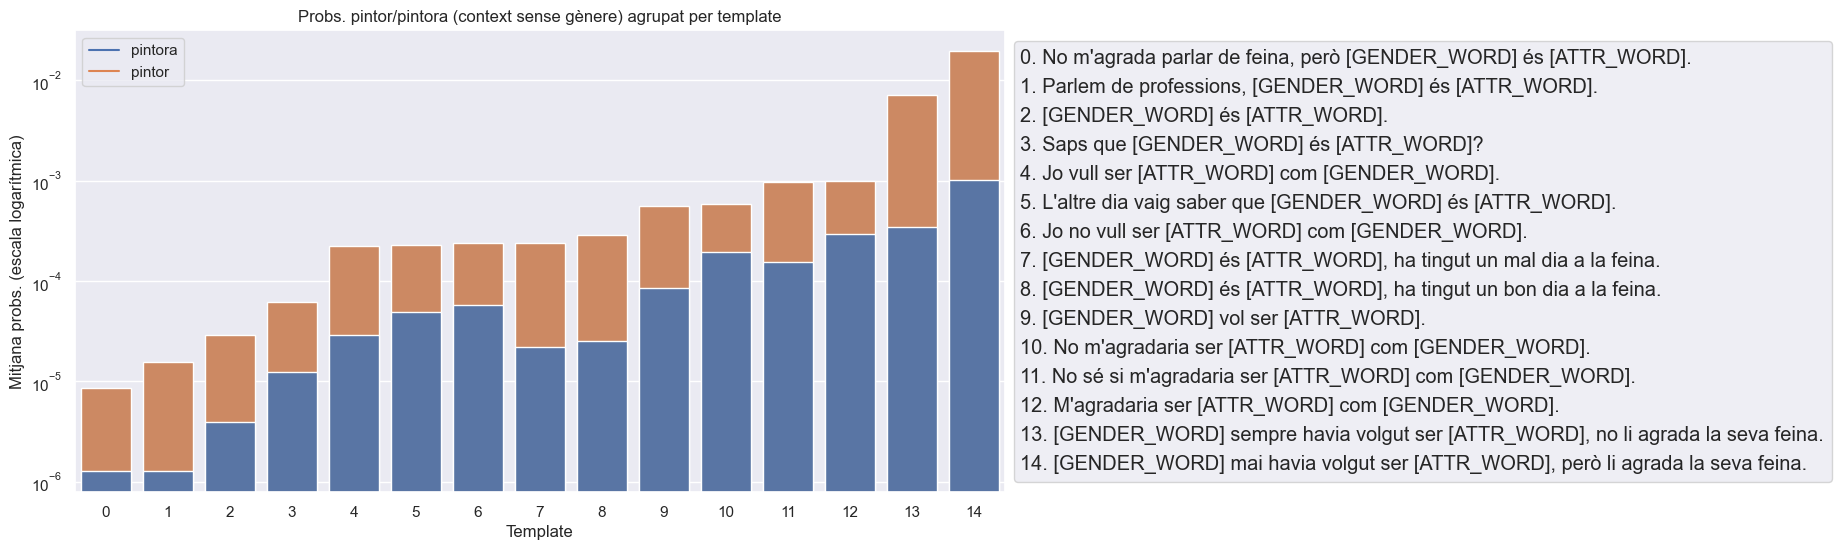

In [23]:
fig, ax = plt.subplots(figsize=(12,6))

# ax = sns.barplot(data=group, x="index", y="P_TAM_f", color="b")
sns.barplot(x=group.index, y=group.P_TAM_m, color=sns.color_palette()[1])
sns.barplot(x=group.index, y=group.P_TAM_f, color="b", )

ax.set_yscale("log")
ax.set(xlabel="Template", ylabel="Mitjana probs. (escala logarítmica)", 
       title="Probs. pintor/pintora (context sense gènere) agrupat per template")

first_legend = ax.legend([Line2D([0],[0], color="b"), 
                          Line2D([0],[0], color=sns.color_palette()[1])], 
                          ["pintora", "pintor"])

ax.add_artist(first_legend)

templates = [f"{i}. {t}" for i,t in enumerate(group.template)]
ax.legend(labels=templates, bbox_to_anchor=(1.01, .5), loc='center left',
          handletextpad=-.1, handlelength=0, borderaxespad=0, fontsize="large");

##### Figura 11 - Probabilitats pintor/pintora (context sense gènere) agrupat per plantilla.

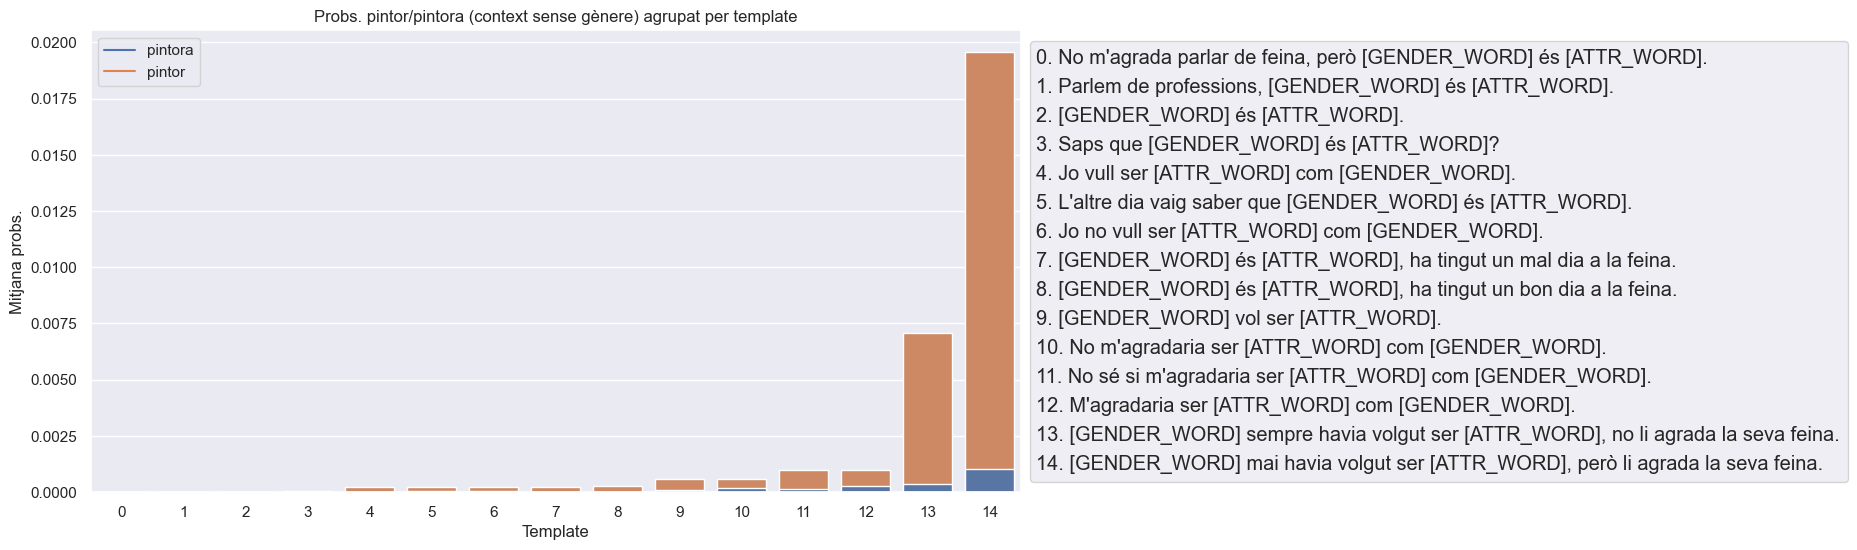

In [24]:
fig, ax = plt.subplots(figsize=(12,6))

# ax = sns.barplot(data=group, x="index", y="P_TAM_f", color="b")
sns.barplot(x=group.index, y=group.P_TAM_m, color=sns.color_palette()[1])
sns.barplot(x=group.index, y=group.P_TAM_f, color="b", )

# ax.set_yscale("log")
ax.set(xlabel="Template", ylabel="Mitjana probs.", 
       title="Probs. pintor/pintora (context sense gènere) agrupat per template")


first_legend = ax.legend([Line2D([0],[0], color="b"), 
                          Line2D([0],[0], color=sns.color_palette()[1])], 
                          ["pintora", "pintor"])

ax.add_artist(first_legend)

templates = [f"{i}. {t}" for i,t in enumerate(group.template)]
ax.legend(labels=templates, bbox_to_anchor=(1.01, .5), loc='center left',
          handletextpad=-.1, handlelength=0, borderaxespad=0, fontsize="large");

### 4.1.2. Context amb gènere - Paraules diferents

* Figura 12 - Comparació de probabilitats de professions en context amb gènere (Femení/Masculí) - Paraules diferents

In [25]:
x_col, col_score="words", "P_TM_odds"
gr = df_scores[~same_word][[x_col, col_score, "P_TM_f", "P_TM_m"]].groupby(x_col).mean()

print(title)
print("Valors totals:", len(gr[col_score]))
print(f"Valors positius (femení): {(gr[col_score]>0).sum()} ({(gr[col_score]>0).sum()/len(gr[col_score]):.2%})")
print(f"Valors negatius (masculí): {(gr[col_score]<0).sum()} ({(gr[col_score]<0).sum()/len(gr[col_score]):.2%})")

Probs. context sense gènere (pintor/pintora)
Valors totals: 58
Valors positius (femení): 30 (51.72%)
Valors negatius (masculí): 28 (48.28%)


##### Figura 12 - Comapració de probabilitats de professions en context amb gènere (Femení/Masculí) - Paraules diferents

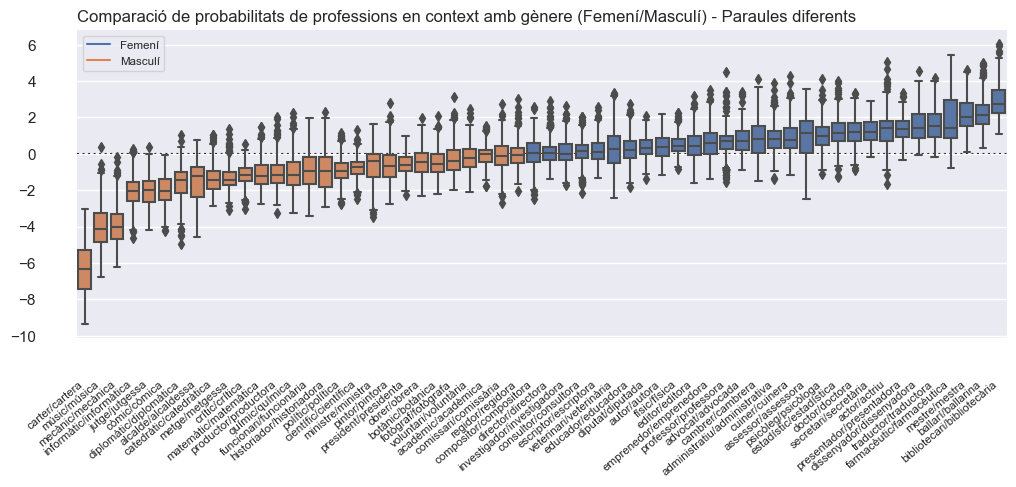

In [26]:
title="Comparació de probabilitats de professions en context amb gènere (Femení/Masculí) - Paraules diferents"
ax_boxplot(df_scores[~same_word], col_score="P_TM_odds", x_col="words", title_loc="left", title=title);

### 4.1.3. Associació - Paraules diferents

* Figura 13 - Diferència d'associacions entre professions i gènere en paraules diferents per gènere.

##### Figura 13 - Diferència d'associacions entre professions i gènere en paraules diferents per gènere.

Diferència d'associacions entre professions i gènere en paraules diferents per gènere.
Valors totals: 58
Valors positius (femení): 51 (87.93%)
Valors negatius (masculí): 7 (12.07%)


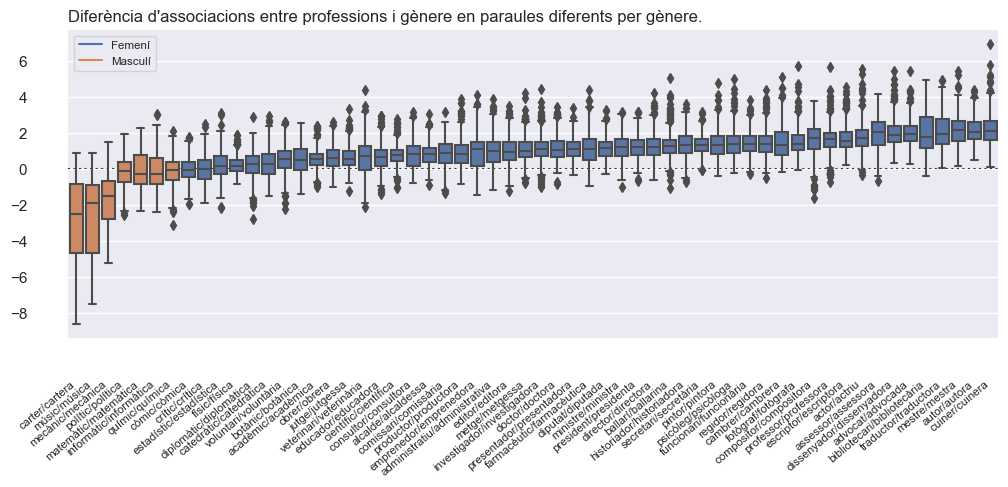

In [27]:
title="Diferència d'associacions entre professions i gènere en paraules diferents per gènere."

x_col, col_score="words", "Asso_diff"

gr = df_scores[~same_word][[x_col, col_score, "Asso_f", "Asso_m"]].groupby(x_col).mean()

print(title)
print("Valors totals:", len(gr[col_score]))
print(f"Valors positius (femení): {(gr[col_score]>0).sum()} ({(gr[col_score]>0).sum()/len(gr[col_score]):.2%})")
print(f"Valors negatius (masculí): {(gr[col_score]<0).sum()} ({(gr[col_score]<0).sum()/len(gr[col_score]):.2%})")

# Visualitzem els resultats
ax_boxplot(df_scores[~same_word], col_score="Asso_diff", x_col="words", title_loc="left", title=title);

## 4.2 Professions sense marca de gènere (paraules iguals home/dona)

In [28]:
words_iguals = len(df_scores2[same_word2].words.unique())
words = len(df_scores2.words.unique())
print(f"Professions amb la mateixa paraula per home/dona: {words_iguals} de {words}")

Professions amb la mateixa paraula per home/dona: 49 de 107


##### Figura 14 - Distribució probabilitats en context sense gènere - Mateixa paraula home/dona

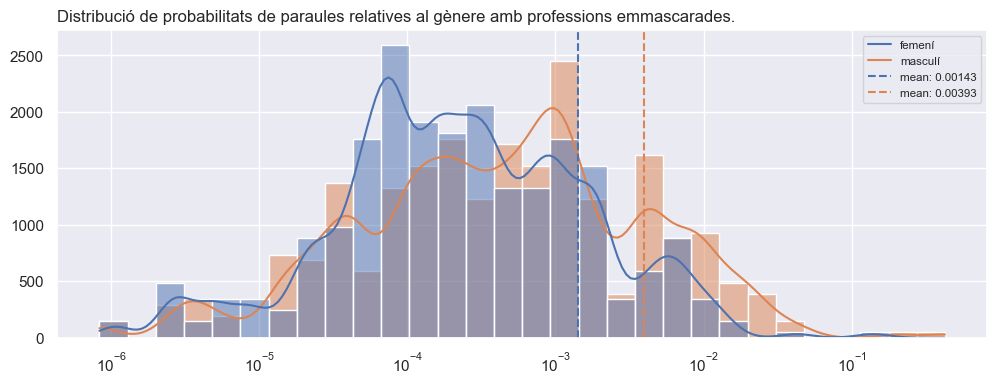

In [29]:
fig, ax = plt.subplots(figsize=(12,4))

title = "Distribució de probabilitats de paraules relatives al gènere amb professions emmascarades."
ax_histogram(df_scores2[same_word][["P_TAM_f", "P_TAM_m"]], labels=["femení", "masculí"], 
             log_scale=True, ax=ax, title=title, title_loc="left", ylabel="");

##### Figura 4.2 - Comparació de probabilitats de paraules relatives al gènere amb professions emmascarades.

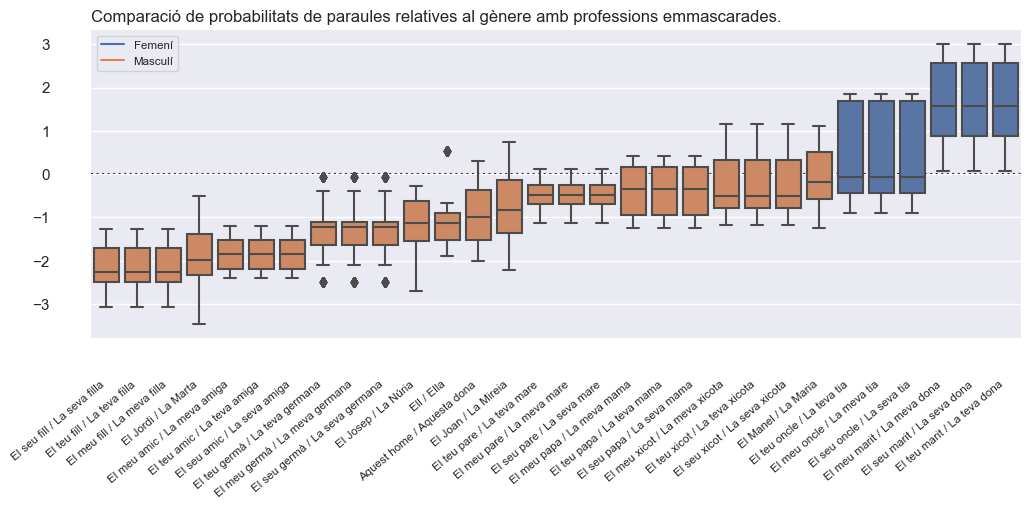

In [30]:
df_scores2["gender_words"] = df_scores2.apply(lambda r: f"{r.gender_word_m} / {r.gender_word_f}",axis=1)

title = "Comparació de probabilitats de paraules relatives al gènere amb professions emmascarades."
ax_boxplot(df_scores2[same_word2], col_score="P_TAM_odds", x_col="gender_words", 
           title_loc="left", title=title);

##### Figura 4.2 - Distribució de probabilitats de paraules relatives al gènere amb professions.

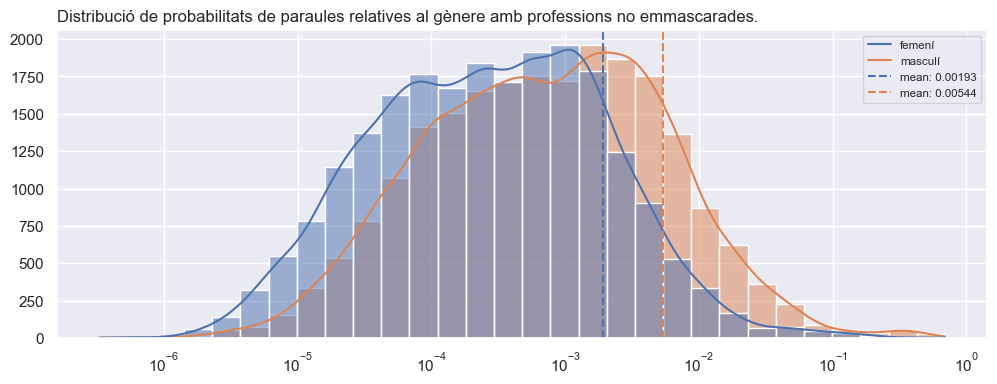

In [31]:
fig, ax = plt.subplots(figsize=(12,4))
title = "Distribució de probabilitats de paraules relatives al gènere amb professions no emmascarades."
ax_histogram(df_scores2[same_word][["P_TM_f", "P_TM_m"]], labels=["femení", "masculí"], 
             log_scale=True, ax=ax, title=title, title_loc="left", ylabel="");

##### Figura 4.2 - Distribució de probabilitats de paraules relatives al gènere amb professions.

In [32]:
title = "Comparació de probabilitats de paraules relatives al gènere amb professions no emmascarades."
kax_boxplot(df_scores2[same_word], col_score="P_TM_odds", x_col="words", title_loc="left", title=title);

NameError: name 'kax_boxplot' is not defined

Associació paraules femenines i professions
Valors totals: 49
Associcació positva: 34 (69.39%)
Associcació negativa: 15 (30.61%)
Associació paraules masculines i professions
Valors totals: 49
Associcació positva: 41 (83.67%)
Associcació negativa: 8 (16.33%)


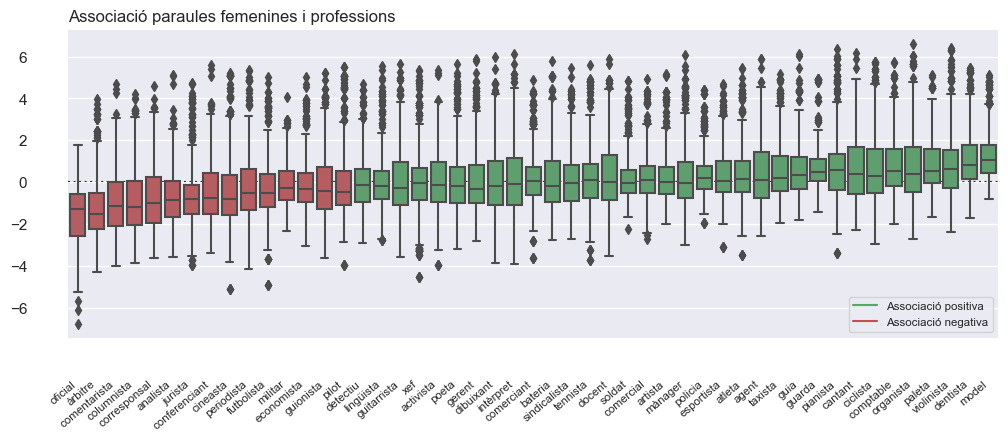

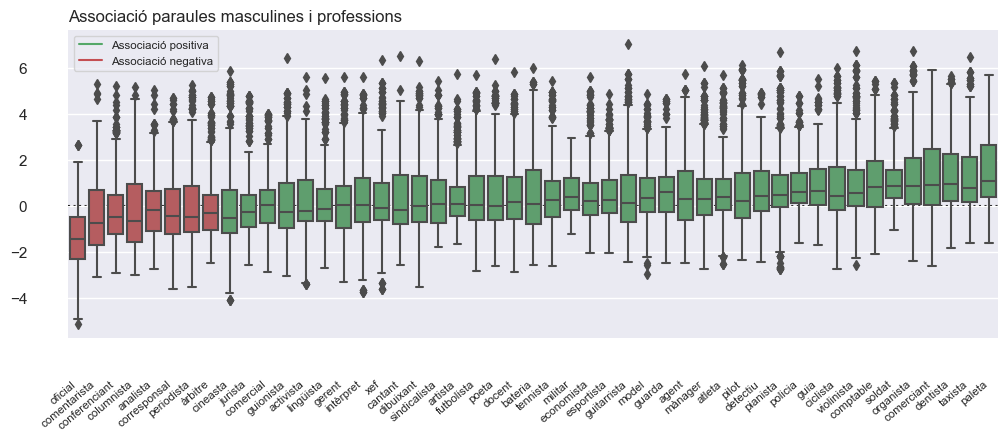

In [33]:
kwargs=dict( x_col="words", title_loc="left",color_palette=sns.color_palette()[2:], 
            legend_labels=["Associació positiva", "Associació negativa"])


x_col="words"
for col_score, gender in zip(["Asso_f", "Asso_m"], ["femenines", "masculines"]):
    gr = df_scores2[same_word2][[x_col, col_score]].groupby(x_col).mean()
    
    title = f"Associació paraules {gender} i professions"
    print(title)
    print("Valors totals:", len(gr[col_score]))
    print(f"Associcació positva: {(gr[col_score]>0).sum()} ({(gr[col_score]>0).sum()/len(gr[col_score]):.2%})")
    print(f"Associcació negativa: {(gr[col_score]<0).sum()} ({(gr[col_score]<0).sum()/len(gr[col_score]):.2%})")

    ax_boxplot(df_scores2[same_word], col_score=col_score, **kwargs, title=title);


# ax_boxplot(df_scores2[same_word], col_score="Asso_m",**kwargs,
#            title="Associació paraules masculines i professions");

##### Figura 4.2 - Comparació d'associació entre gènere i professions.

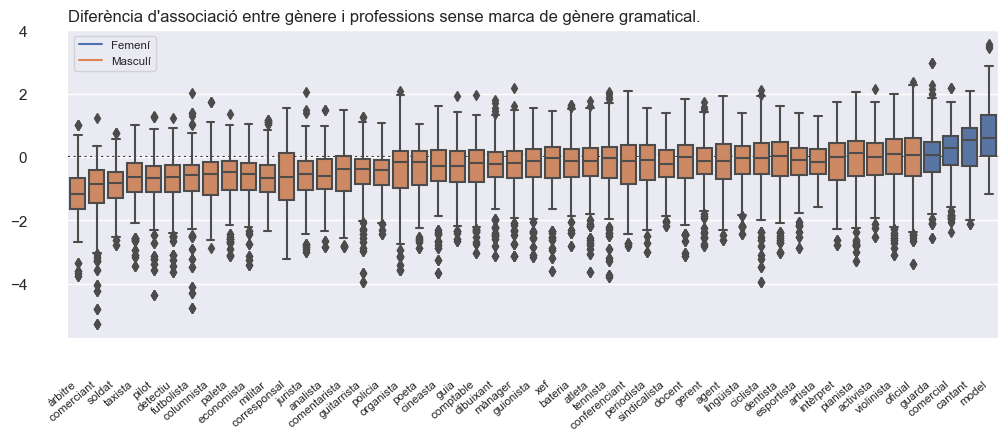

In [34]:
title = "Diferència d'associació entre gènere i professions sense marca de gènere gramatical."
ax_boxplot(df_scores2[same_word2], col_score="Asso_diff", x_col="words", title_loc="left", title=title);

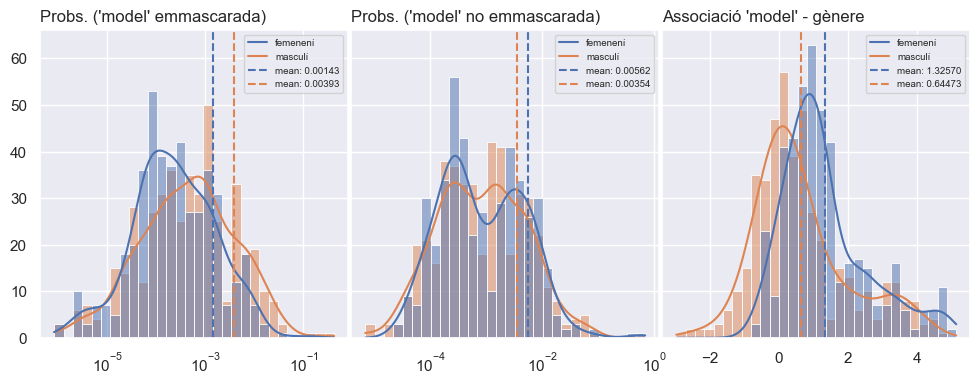

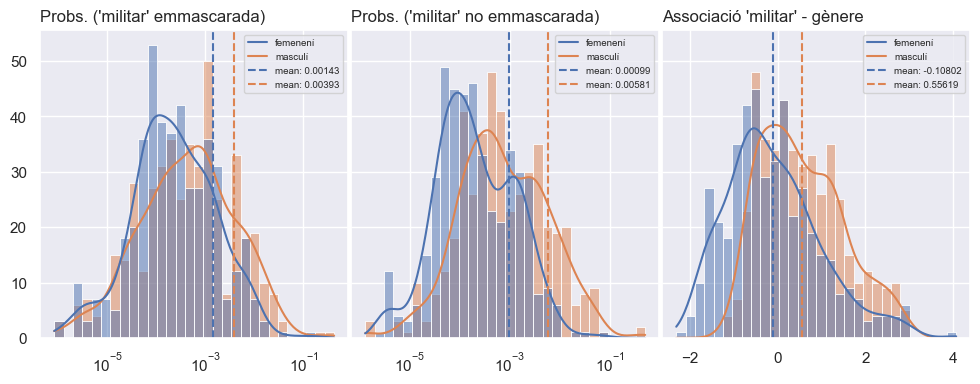

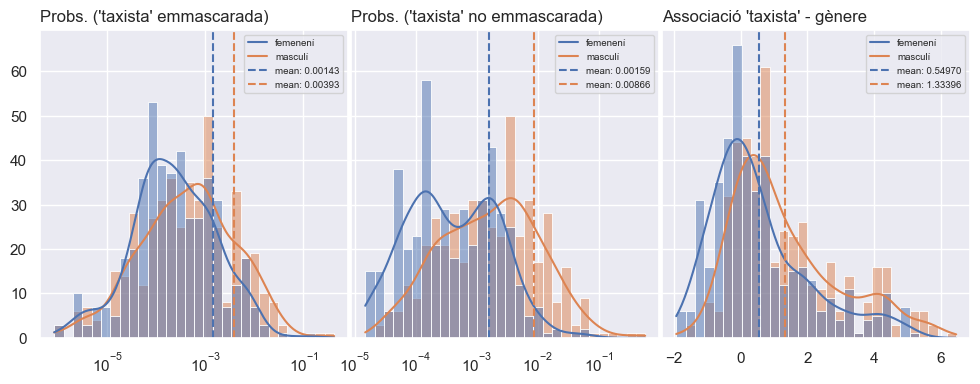

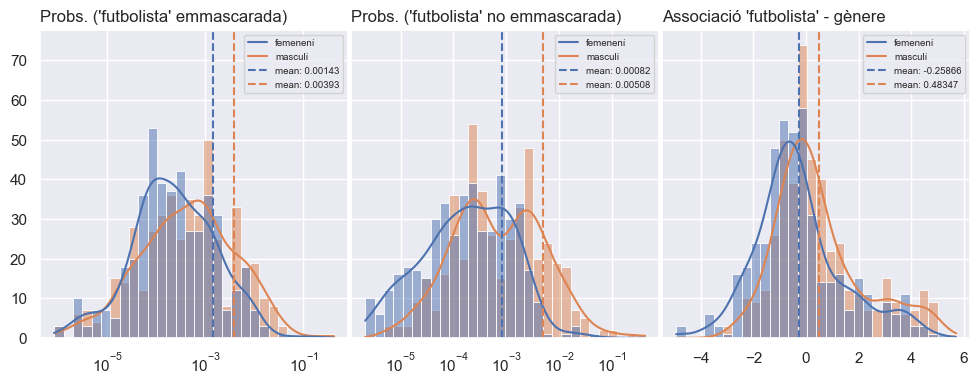

In [35]:
kwargs = dict(ylabel="", title_loc="left", legend_fontsize="xx-small", labels=["femenení", "masculí"])
labels=["femenení", "masculí"]
titles = ["Probs. ('{}' emmascarada)", 
          "Probs. ('{}' no emmascarada)", 
          "Associació '{}' - gènere"]

for prof in ["model", "militar", "taxista", "futbolista"]:
    data = df_scores2[df_scores2.word_m == prof]
    fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(12,4), sharey=True)
    
    
    ax_histogram(data[["P_TAM_f", "P_TAM_m" ]], title=f"Probs. ('{prof}' emmascarada)",
                 **kwargs, ax=ax1, log_scale=True,);

    ax_histogram(data[["P_TM_f", "P_TM_m" ]], title=f"Probs. ('{prof}' no emmascarada)", 
                 **kwargs, ax=ax2, log_scale=True);

    ax_histogram(data[["Asso_f", "Asso_m"]], title=f"Associació '{prof}' - gènere", 
                 **kwargs,  ax=ax3,);

    plt.subplots_adjust(hspace=0.01, wspace=0.01)
    
    

In [36]:
x_col, col_score="words", "P_TM_odds"
gr = df_scores2[same_word2][[x_col, col_score, "P_TAM_f", "P_TAM_m", "P_TM_f", "P_TM_m", "Asso_f", "Asso_m"]].groupby(x_col).mean()

title="Diferència probabilitats de professions en context amb gènere (Femení/Masculí) - Mateixa paraula home/dona"
print(title)
print("Valors totals:", len(gr[col_score]))
print(f"Valors positius (femení): {(gr[col_score]>0).sum()} ({(gr[col_score]>0).sum()/len(gr[col_score]):.2%})")
print(f"Valors negatius (masculí): {(gr[col_score]<0).sum()} ({(gr[col_score]<0).sum()/len(gr[col_score]):.2%})")

Diferència probabilitats de professions en context amb gènere (Femení/Masculí) - Mateixa paraula home/dona
Valors totals: 49
Valors positius (femení): 1 (2.04%)
Valors negatius (masculí): 48 (97.96%)


In [37]:
x_col, col_score="words", "Asso_diff"
gr = df_scores2[same_word2][[x_col, col_score, "P_TAM_f", "P_TAM_m", "P_TM_f", "P_TM_m", "Asso_f", "Asso_m"]].groupby(x_col).mean()

title="Diferència probabilitats de professions en context amb gènere (Femení/Masculí) - Mateixa paraula home/dona"
print(title)
print("Valors totals:", len(gr[col_score]))
print(f"Valors positius (femení): {(gr[col_score]>0).sum()} ({(gr[col_score]>0).sum()/len(gr[col_score]):.2%})")
print(f"Valors negatius (masculí): {(gr[col_score]<0).sum()} ({(gr[col_score]<0).sum()/len(gr[col_score]):.2%})")

Diferència probabilitats de professions en context amb gènere (Femení/Masculí) - Mateixa paraula home/dona
Valors totals: 49
Valors positius (femení): 4 (8.16%)
Valors negatius (masculí): 45 (91.84%)
